In [10]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib
from natsort import natsorted
from scipy.sparse.linalg import svds

In [11]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [310]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))

def cnum(xbinw,ebinw,num_components):
    R = []
    D = []

    for i in range(5,len(g4iso_files),ebinw): # 100 keV to 1 MeV energy range in steps of 100 keV
        R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:2000:xbinw,3]/5000000.0)
    R = np.transpose(np.array(R))
    u, s, v = svds(R, k=min(R.shape)-num_components)
    R = u.dot(np.diag(s))  # output of TruncatedSVD
    
    return(np.linalg.cond(R))


def tsvd_R(xbinw,ebinw,num_components,fold,total):
    R = []
    D = []

    for i in range(5,len(g4iso_files),ebinw): # 100 keV to 1 MeV energy range in steps of 100 keV
        R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:2000:xbinw,3]/5000000.0)
    R = np.transpose(np.array(R))
    u, s, v = svds(R, k=R.shape[1]-num_components)
    R = u.dot(np.diag(s))  # output of TruncatedSVD
    elow_keV = 100
    ehigh_keV = 1000
    xspace_estep_keV = xbinw
    espace_estep_keV = ebinw
    
    e0 = np.linspace(30, 299, R.shape[0])
    e1 = np.linspace(100, ehigh_keV, R.shape[1])
    
    espace = np.linspace(elow_keV,ehigh_keV,R.shape[1])
    xspace = np.linspace(30,500,R.shape[0])
    
    beam = np.exp(-e1/fold)
    integral = np.trapz(beam,e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    signal = abs(np.matmul(R,beam))
    
    for e in range(0, e0.shape[0]):
        signal[e] = signal[e] + np.random.normal(signal[e],np.sqrt(abs(signal[e])))
    
    
    return([R,xspace,espace,abs(signal),beam])

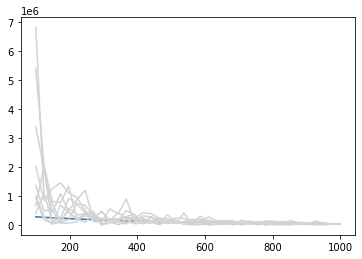

In [317]:
tt=tsvd_R(1,5,1,400,1e8)
plt.plot(tt[2],tt[4])
for i in range(1,10):
    tt=tsvd_R(1,5,1,400,1e8)
    plt.plot(tt[2],abs(np.matmul(np.linalg.pinv(tt[0]),tt[3]))/2,color='lightgrey')

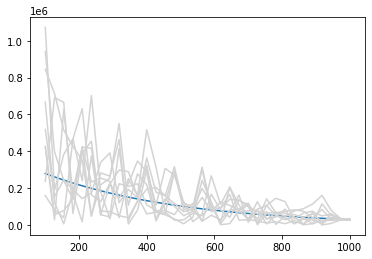

In [319]:
tt=tsvd_R(1,5,5,400,1e8)
plt.plot(tt[2],tt[4])
for i in range(1,10):
    tt=tsvd_R(1,5,5,400,1e8)
    plt.plot(tt[2],abs(np.matmul(np.linalg.pinv(tt[0]),tt[3]))/2,color='lightgrey')

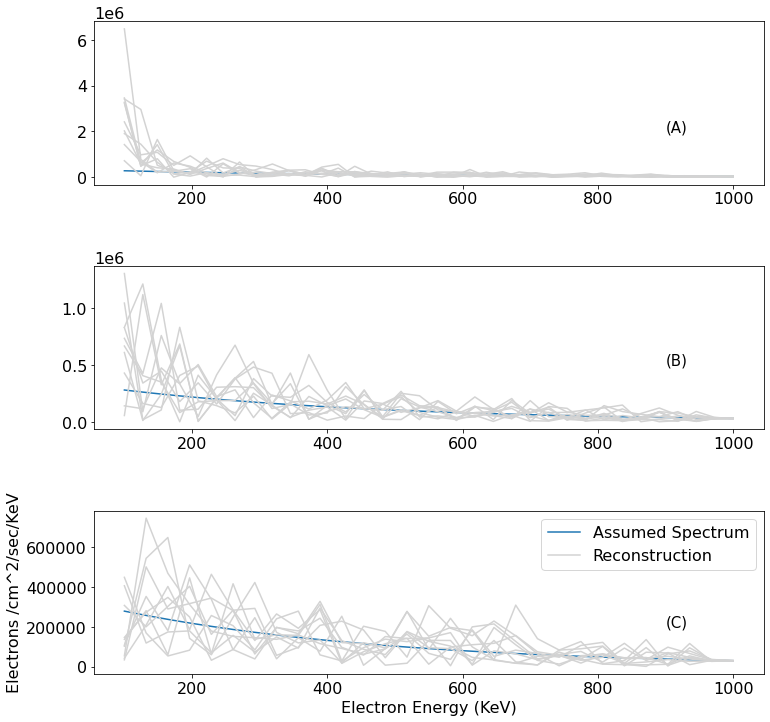

In [332]:
np.random.seed(231)
fig = plt.figure(figsize=(12,12))
gs = plt.GridSpec(nrows=3, ncols=1,hspace=.5,wspace=.3)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

tt=tsvd_R(1,5,1,400,1e8)
ax1.plot(tt[2],tt[4],label='Assumed Spectrum')
ax1.plot(tt[2],abs(np.matmul(np.linalg.pinv(tt[0]),tt[3]))/2,color='lightgrey',label='Reconstruction')
for i in range(1,10):
    tt=tsvd_R(1,5,1,400,1e8)
    ax1.plot(tt[2],abs(np.matmul(np.linalg.pinv(tt[0]),tt[3]))/2,color='lightgrey')

tt=tsvd_R(1,5,5,400,1e8)
ax2.plot(tt[2],tt[4],label='Assumed Spectrum')
ax2.plot(tt[2],abs(np.matmul(np.linalg.pinv(tt[0]),tt[3]))/2,color='lightgrey',label='Reconstruction')
for i in range(1,10):
    tt=tsvd_R(1,5,5,400,1e8)
    ax2.plot(tt[2],abs(np.matmul(np.linalg.pinv(tt[0]),tt[3]))/2,color='lightgrey')

tt=tsvd_R(1,5,10,400,1e8)
ax3.plot(tt[2],tt[4],label='Assumed Spectrum')
ax3.plot(tt[2],abs(np.matmul(np.linalg.pinv(tt[0]),tt[3]))/2,color='lightgrey',label='Reconstruction')
for i in range(1,10):
    tt=tsvd_R(1,5,10,400,1e8)
    ax3.plot(tt[2],abs(np.matmul(np.linalg.pinv(tt[0]),tt[3]))/2,color='lightgrey')
ax3.legend()




ax3.set_ylabel('Electrons /cm^2/sec/KeV')
ax3.set_xlabel('Electron Energy (KeV)')

ax1.text(900, 2e6, '(A)', fontsize=15)
ax2.text(900, .5e6, '(B)', fontsize=15)
ax3.text(900, .2e6, '(C)', fontsize=15)


plt.savefig('fig_7.pdf')  

